## Загружаем необходимые библиотеки

In [ ]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

import librosa   #библиотека для обработки аудио
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #для обработки аудио
import warnings
warnings.filterwarnings("ignore")

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.6.0


## 1. Получение данных

### 1.1. Загружаем аудио-файлы в список all_wave, названия аудио-файлов в all_label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Папка с аудио данными
data_dir = Path("/content/drive/MyDrive/Colab_Notebooks/adata")

# Получаем список всех аудио-файлов
waves = list(data_dir.glob("*.wav"))

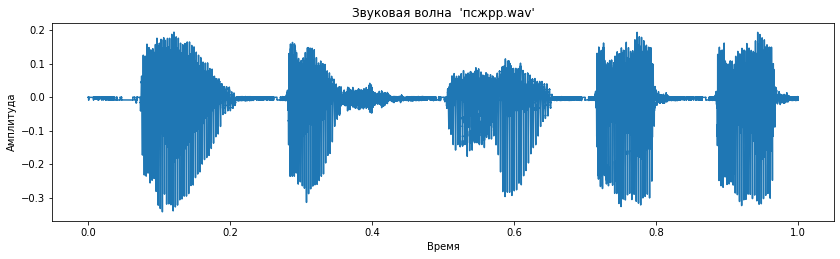

In [ ]:
samples, sample_rate = librosa.load(waves[0], sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Звуковая волна  {repr(waves[0].name)}' )
ax1.set_xlabel('Время')
ax1.set_ylabel('Амплитуда')
ax1.plot(np.linspace(0, 1, len(samples)), samples)
plt.show()

In [ ]:
ipd.Audio(str(waves[0]), rate=22050)

In [ ]:
all_wave = []
all_label = []
characters = set()

max_len = 0
for wav in waves:
    samples, sample_rate = librosa.load(wav)
    #samples = librosa.resample(samples, sample_rate, 8000)
    max_len = max(max_len, len(samples))
    all_wave.append(samples)
    label = wav.stem
    all_label.append(label)
    for ch in label:
        characters.add(ch)


In [ ]:
#characters = {'2', '4', '5', '6', '7', '8', '9', 'б', 'в', 'г', 'д', 'ж', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т'}
print(f'Имеющиеся символы: {sorted(characters)}')

Имеющиеся символы: ['2', '4', '5', '6', '7', '8', '9', 'б', 'в', 'г', 'д', 'ж', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т']


### 2.1. Выравниваваем длительность загруженных аудио-файлов по найденной максимальной длительности 
### и получаем Mel-спектрограмму каждого аудио-файла

#### Mel-частотные характеристики хорошо себя показывают в задачах распознавания речи. Мел — психофизическая единица высоты звука, применяемая главным образом в музыкальной акустике. В шкале мел любое равное расстояние между частотами звучит для человеческого уха одинаково. Единица мел (m) связана с герцами (f) таким уравнением:
 #### $$m = 2595 * log(1 + f/700)$$
 #### Спектрограмма на мел-шкале — это просто спектрограмма с частотами, измеренными в мел.

In [ ]:
realigned = []

for sample in all_wave:
    # Выравниваем векторы по одной длине равной max_len
    new = np.zeros((max_len))
    new[:len(sample)] = sample
    
    new = librosa.feature.melspectrogram(y=new, sr=sample_rate)
    #new = new.reshape(len(new)*len(new[0]))
    #new = librosa.util.normalize(new)
    realigned.append(new)

Размер одной мел-спектрограммы: (128, 131)


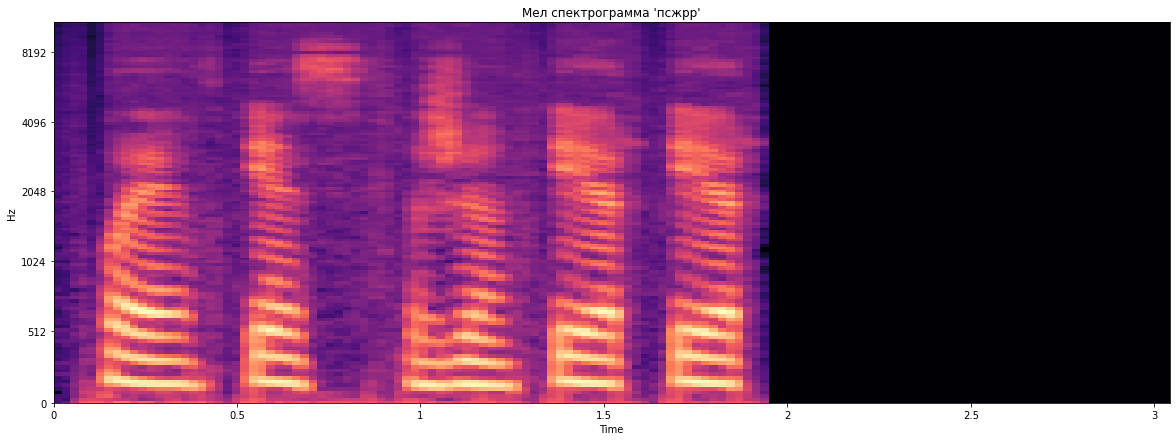

In [ ]:
# Отображение Мел спектрограммы аудио-файла:
print('Размер одной мел-спектрограммы:', new.shape)
plt.figure(figsize=(20, 7))
librosa.display.specshow(librosa.power_to_db(realigned[0], ref=np.max),  x_axis='time',  y_axis='mel')
plt.title(f'Мел спектрограмма {repr(all_label[0])}')
plt.show()

## 3. Подготовка данных для обучения 

### 3.1. Разделим dataset на тренировочную и валидационную выборки

In [ ]:
training_data, validation_data, training_labels, validation_labels = train_test_split(np.array(realigned), all_label, 
                                                                                      test_size=0.2, random_state=seed)

### 3.2. Функции для работы с данными

In [ ]:
# Получим индексы символов по их месту в списке
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Получим символы по их индексам в списке
labels_to_char = {val:key for key, val in char_to_labels.items()}

# Проверка символов в названиях аудио-файлов по проверочным символам 
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

class DataGenerator(keras.utils.Sequence):
    """Создает пакеты из заданного dataset.
    
    Args:
        data: training или validation data
        labels: соответствующие метки
        char_map: сопоставление символов словаря с метками
        batch_size: размер одной партии
        wav_length: высота изображений с измененным размером
        downsample_factor: по какому фактору CNN снизила качество изображений
        max_length: максимальная длина любой капчи
        shuffle: следует ли перетасовывать данные или нет после каждой эпохи
    Returns:
        batch_inputs: словарь, содержащий пакетные входные данные
        batch_labels: пакет соответствующих меток
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=131,
                 img_height=128,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Получим индексы следующей партии
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. В этом нет необходимости, но это может помочь нам сэкономить немного памяти,
        # так как не во всех пакетах в последнем пакете могут отсутствовать элементы
        # равные размеру пакета
        batch_len = len(curr_batch_idx)
        
        # 3. Создание экземпляров пакетных массивов
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2) #48
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Получим изображение и транспонируем его
            img = self.data[idx].T
            # 2. Добавим дополнительное измерение
            img = np.expand_dims(img, axis=-1)
            # 3. Получим соответствующую метку
            text = self.labels[idx]
            
            # 4. Включим данные только в том случае, если капча действительна
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Размер пакета для training и validation
batch_size = 16

# Желаемые размеры изображения
img_width = 131
img_height = 128
#Коэффициент, на который изображение будет уменьшено с
# помощью сверточных блоков
downsample_factor=4

# Максимальная длина любой капчи в данных
max_length=5

# Получим объект-генератор для training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Получим объект-генератор для validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

## 4. Установка параметров модели

### 4.1. Добавим Connectionist Temporal Classification слой, который будет возвращать loss для последовательности предсказываемых симоволов

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, BatchNormalization
from keras import backend as K
K.clear_session()

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Вычислияем значение training-time loss и добавим его
        # в слой с помощью `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # Во время тестирования возвращает вычисленный loss
        return loss

### 4.2. Добавим необходимые слои нейронной сети

In [ ]:
    
inputs = layers.Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
labels = layers.Input(name='input_label', shape=[5], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
# Первый conv block
x = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv1')(inputs)
x = layers.MaxPooling2D((2,2), name='pool1')(x)

# Второй conv block
x = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
x = layers.MaxPooling2D((2,2), name='pool2')(x)

# new_shape = ((wav_length // 1)*64)
x = layers.Reshape(target_shape=(32, 32*64), name='reshape')(x)
x = layers.Dense(64, activation='relu', name='dense1')(x)
x = layers.Dropout(0.2)(x)
    
# RNNs
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Predictions
x = layers.Dense(len(characters)+1, activation='softmax', name='dense2', kernel_initializer='he_normal')(x)

# Вычисляем CTC
output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)

# Определяем модель
model = keras.models.Model(inputs=[inputs, labels, input_length, label_length],
                            outputs=output, name='ocr_model_v2')

# Оптимизатор
adam = keras.optimizers.Adam(clipnorm=5)

# Компилируем модель
model.compile(optimizer=adam)

In [ ]:
model.summary()

Model: "ocr_model_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 131, 128, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 131, 128, 32) 320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 65, 64, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 65, 64, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

## 5. Обучаем модель

### 5.1.

In [ ]:
history=model.fit(train_data_generator ,epochs=30, batch_size=16, validation_data=valid_data_generator)

Epoch 1/30
9/9 [==============================] - 13s 344ms/step - loss: 57.8461 - val_loss: 40.7395
Epoch 2/30
9/9 [==============================] - 1s 88ms/step - loss: 30.3289 - val_loss: 22.8043
Epoch 3/30
9/9 [==============================] - 1s 91ms/step - loss: 18.2036 - val_loss: 14.1504
Epoch 4/30
9/9 [==============================] - 1s 93ms/step - loss: 12.1240 - val_loss: 8.2405
Epoch 5/30
9/9 [==============================] - 1s 94ms/step - loss: 7.8637 - val_loss: 4.0556
Epoch 6/30
9/9 [==============================] - 1s 89ms/step - loss: 4.3857 - val_loss: 1.4452
Epoch 7/30
9/9 [==============================] - 1s 94ms/step - loss: 2.1966 - val_loss: 0.5509
Epoch 8/30
9/9 [==============================] - 1s 94ms/step - loss: 1.1238 - val_loss: 0.2732
Epoch 9/30
9/9 [==============================] - 1s 91ms/step - loss: 0.6137 - val_loss: 0.1032
Epoch 10/30
9/9 [==============================] - 1s 92ms/step - loss: 0.3264 - val_loss: 0.0842
Epoch 11/30
9/9 [===

### 5.2. Сохраняем веса модели

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab_Notebooks/adata/m1.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab_Notebooks/adata/m1.h5")

## 6. Предсказываем результаты на тестовой выборке 

### 6.1. Функция для декодирования выходных данных (output) сети

In [ ]:
  def decode_batch_predictions(pred):
    pred = pred[:, :-2] #48
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Используем жадный (greedy) поиск. Для сложных задач можно использовать beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    # Повторим результаты и вернем текст
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # вернем окончательные результаты текста
    return output_text

### 6.2. Подготовим тестовые данные

In [ ]:
# Папки с данными
data_dir = Path("/content/drive/MyDrive/Colab_Notebooks/adata_test")

# Получаем список всех изображений
test_waves = list(data_dir.glob("*.wav"))

In [ ]:
all_wave_test = []
all_label_test = []

for wav in test_waves:
    samples, sample_rate = librosa.load(wav)
    #samples = librosa.resample(samples, sample_rate, 8000)
    #if(len(samples)== 16000) :
    all_wave_test.append(samples)
    label = str(wav).split('/')[-1].split('.')[0]
    all_label_test.append(label)


In [ ]:
test_realigned = []

for sample in all_wave_test:
    # Выравниваем векторы по длине 
    new = np.zeros((max_len))
    new[:len(sample)] = sample
    
    new = librosa.feature.melspectrogram(y=new, sr=sample_rate)
    #new = new.reshape(len(new)*len(new[0]))
    #new = librosa.util.normalize(new)
    test_realigned.append(new)

In [ ]:
test_data_generator = DataGenerator(data=np.array(test_realigned),
                                     labels=all_label_test,
                                     char_map=char_to_labels,
                                     batch_size=len(test_realigned),
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

### 6.3. Подготовим модель для декодирования данных

In [ ]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 131, 128, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 131, 128, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 65, 64, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 65, 64, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 2048)          0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)            131136

### 6.4. Проверяем результаты на тестовой выборке

In [ ]:

true_preds = 0   
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)

     
    for i in range(bs):
        print(f'Оригинальный текст: {orig_texts[i]} \t Предсказанный: {pred_texts[i]} {orig_texts[i]==pred_texts[i]}')
        if orig_texts[i]==pred_texts[i]:
            true_preds+=1
    break

print(true_preds/bs)

Оригинальный текст: жлвр6 	 Предсказанный: жлвр6 True
Оригинальный текст: п6кв4 	 Предсказанный: п6кв4 True
Оригинальный текст: п5р85 	 Предсказанный: п5р85 True
Оригинальный текст: д4вгб 	 Предсказанный: д4вгб True
Оригинальный текст: жб255 	 Предсказанный: жб255 True
Оригинальный текст: лп6б2 	 Предсказанный: лп6б2 True
Оригинальный текст: п6сжг 	 Предсказанный: п6сжг True
Оригинальный текст: жквт8 	 Предсказанный: жквт8 True
Оригинальный текст: п47рн 	 Предсказанный: п47рн True
Оригинальный текст: д6кж6 	 Предсказанный: д6кж6 True
Оригинальный текст: пж5бк 	 Предсказанный: пж5бк True
Оригинальный текст: лтлп9 	 Предсказанный: лтлп9 True
Оригинальный текст: пвлрв 	 Предсказанный: пвлрв True
Оригинальный текст: дгглр 	 Предсказанный: дгглр True
Оригинальный текст: л7птк 	 Предсказанный: л7птк True
Оригинальный текст: ж66пд 	 Предсказанный: ж66пд True
Оригинальный текст: дс4в5 	 Предсказанный: дс4в5 True
Оригинальный текст: пм2дг 	 Предсказанный: пм2дг True
Оригинальный текст: п45мк 	 

## 7. Выводы

### 7.1. Модель выдала 100% результат на тестовой выборке

 ### 8. Ссылки
 #### 8.1. https://habr.com/ru/company/skillfactory/blog/536834/
 #### 8.2. https://medium.com/nuances-of-programming/анализ-аудиоданных-с-помощью-глубокого-обучения-и-python-часть-1-2056fef8525e
 #### 8.3. https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/
 #### 8.4. https://www.gibiansky.com/blog/machine-learning/speech-recognition-neural-networks/
 #### 8.5. http://proceedings.mlr.press/v32/graves14.pdf
 #### 8.6. https://www.azoft.ru/blog/how-to-train-a-neural-network-to-recognize-speech/
 #### 8.7. https://www.machinelearningmastery.ru/recognizing-speech-commands-using-recurrent-neural-networks-with-attention-c2b2ba17c837/
 #### 8.8. https://jonathan-hui.medium.com/speech-recognition-deep-speech-ctc-listen-attend-and-spell-d05e940e9ed1
 #### 8.9. https://github.com/douglas125/SpeechCmdRecognition/blob/master/Speech_Recog_Demo.ipynb
 #### 8.10. 
